# Deep Learning Homework 2

In [7]:
# check whether the torch cuda is ok
import torch
import os
os.environ['CUDA_VISIBLE_DEVICES']='0,1'
torch.cuda.is_available()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
%matplotlib inline

## Task A


In [10]:
# import data
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import os

## Note that: here we provide a basic solution for loading data and transforming data.
## You can directly change it if you find something wrong or not good enough.

## the mean and standard variance of imagenet dataset
## mean_vals = [0.485, 0.456, 0.406]
## std_vals = [0.229, 0.224, 0.225]

def load_data(data_dir = "dataset/",input_size = 224,batch_size = 36):
    data_transforms = {
        'train': transforms.Compose([
            transforms.RandomResizedCrop(input_size),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        'test': transforms.Compose([
            transforms.Resize(input_size),
            transforms.CenterCrop(input_size),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
    }
    ## The default dir is for the first task of large-scale deep learning
    ## For other tasks, you may need to modify the data dir or even rewrite some part of 'data.py'
    image_dataset_train = datasets.ImageFolder(os.path.join(data_dir, '1-Large-Scale', 'train'), data_transforms['train'])
    image_dataset_valid = datasets.ImageFolder(os.path.join(data_dir,'test'), data_transforms['test'])

    train_loader = DataLoader(image_dataset_train, batch_size=batch_size, shuffle=True, num_workers=4)
    valid_loader = DataLoader(image_dataset_valid, batch_size=batch_size, shuffle=False, num_workers=4)

    return train_loader, valid_loader


# load the trained model
def load_model(device,model_name,optimizer_name):
    return torch.load(model_name+" with "+optimizer_name+ " best_model.pt",device)


In [4]:
from torchvision import models
import torch.nn as nn


def model_A(num_classes):
    model_resnet = models.resnet18(pretrained=False)
    num_features = model_resnet.fc.in_features
    model_resnet.fc = nn.Linear(num_features, num_classes)
    model_resnet.name = "Large-Scale Learning"
    return model_resnet



In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import os
from torch.utils.tensorboard import SummaryWriter

## Note that: here we provide a basic solution for training and validation.
## You can directly change it if you find something wrong or not good enough.

def train_model(model,train_loader, valid_loader, criterion, optimizer, num_epochs=20, logdir = 'logs'):
    def train(model, train_loader,optimizer,criterion):
        model.train(True)
        total_loss = 0.0
        total_correct = 0
        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, predictions = torch.max(outputs, 1)
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * inputs.size(0)
            total_correct += torch.sum(predictions == labels.data)

        epoch_loss = total_loss / len(train_loader.dataset)
        epoch_acc = total_correct.double() / len(train_loader.dataset)
        return epoch_loss, epoch_acc.item()

    def valid(model, valid_loader,criterion):
        model.train(False)
        total_loss = 0.0
        total_correct = 0
        for inputs, labels in valid_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, predictions = torch.max(outputs, 1)
            total_loss += loss.item() * inputs.size(0)
            total_correct += torch.sum(predictions == labels.data)
        epoch_loss = total_loss / len(valid_loader.dataset)
        epoch_acc = total_correct.double() / len(valid_loader.dataset)
        return epoch_loss, epoch_acc.item()

    best_acc = 0.0
    train_loss_curves = []
    train_acc_curves = []
    valid_loss_curves = []
    valid_acc_curves = []
    writer = SummaryWriter(os.path.join(logdir,model.name + ' with ' + optimizer.name))
    for epoch in range(num_epochs):
        print('epoch:{:d}/{:d}'.format(epoch, num_epochs))
        print('*' * 100)
        train_loss, train_acc = train(model, train_loader,optimizer,criterion)
        print("training: {:.4f}, {:.4f}".format(train_loss, train_acc))
        valid_loss, valid_acc = valid(model, valid_loader,criterion)
        print("validation: {:.4f}, {:.4f}".format(valid_loss, valid_acc))
        train_acc_curves.append(train_acc)
        train_loss_curves.append(train_loss)
        valid_acc_curves.append(valid_acc)
        valid_loss_curves.append(valid_loss)
        writer.add_scalars(os.path.join(model.name+" with "+optimizer.name,'loss curves'),{'train':train_loss,'valid':valid_loss},epoch)
        writer.add_scalars(os.path.join(model.name+" with "+optimizer.name,'acc curves'),{'train':train_acc,'valid':valid_acc},epoch)
        if valid_acc > best_acc:
            best_acc = valid_acc
            best_model = model
            torch.save(best_model, model.name+' with '+optimizer.name +' best_model.pt')
    writer.close()
    return train_loss_curves,train_acc_curves,valid_loss_curves,valid_acc_curves

import numpy as np
import matplotlib.pyplot as plt
import os

def show_loss_curve(train_loss_curve,valid_loss_curve,name="temporary name",savedir=os.path.join('results','loss curve results')):
    num_epochs = len(train_loss_curve)
    epochs = np.linspace(1,num_epochs,num=num_epochs,endpoint=True)
    plt.plot(epochs,train_loss_curve,color='red',linestyle='-',label="train")
    plt.plot(epochs,valid_loss_curve,color='green',linestyle='-',label="valid")
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.title("the loss curves (train & valid) of " + name)
    ax=plt.gca()
    ax.xaxis.set_ticks_position('bottom')
    plt.savefig(os.path.join(savedir,"loss curves of "+ name+".png"))
    plt.show()
    
def show_acc_curve(train_acc_curve,valid_acc_curve,name="temporary name",savedir=os.path.join('results','acc curve results')):
    num_epochs = len(train_acc_curve)
    epochs = np.linspace(1,num_epochs,num=num_epochs,endpoint=True)
    plt.plot(epochs,train_acc_curve,color='red',linestyle='-',label="train")
    plt.plot(epochs,valid_acc_curve,color='green',linestyle='-',label="valid")
    plt.xlabel("epochs")
    plt.ylabel("acc")
    plt.title("the acc curves (train & valid) of " + name)
    ax=plt.gca()
    ax.xaxis.set_ticks_position('bottom')
    plt.savefig(os.path.join(savedir,"acc curves of " + name +".png"))
    plt.show()

epoch:0/100
****************************************************************************************************
training: 1.3567, 0.5479
validation: 1.1757, 0.5859
epoch:1/100
****************************************************************************************************
training: 0.9245, 0.6814
validation: 1.7224, 0.4604
epoch:2/100
****************************************************************************************************
training: 0.7935, 0.7272
validation: 0.7328, 0.7343
epoch:3/100
****************************************************************************************************
training: 0.7281, 0.7457
validation: 0.8233, 0.6865
epoch:4/100
****************************************************************************************************
training: 0.6697, 0.7661
validation: 0.7124, 0.7446
epoch:5/100
****************************************************************************************************
training: 0.6201, 0.7861
validation: 0.6164, 0.7846
epoch:6/10

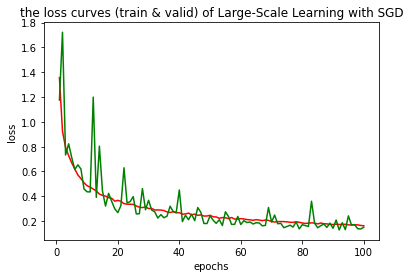

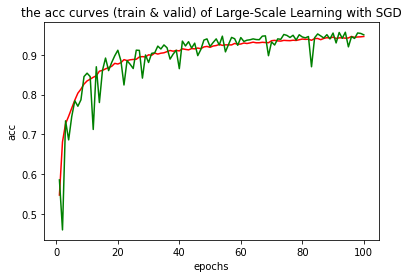

In [5]:
## about model
num_classes = 10

## about data
data_dir = "dataset/" ## You need to specify the data_dir first
input_size = 224
batch_size = 128

## about training
num_epochs = 100
lr = 0.001

## model initialization
model = model_A(num_classes=num_classes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

## data preparation
train_loader, valid_loader = load_data(data_dir=data_dir,input_size=input_size, batch_size=batch_size)

## optimizer
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
optimizer.name = 'SGD'
## loss function
criterion = nn.CrossEntropyLoss()
train_loss_curves,train_acc_curves,valid_loss_curves,valid_acc_curves = train_model(model,train_loader, valid_loader, criterion, optimizer, num_epochs=num_epochs)
show_loss_curve(train_loss_curves,valid_loss_curves,model.name+" with "+optimizer.name)
show_acc_curve(train_acc_curves,valid_acc_curves,model.name+" with "+optimizer.name)


## Use RMSProp

epoch:0/100
****************************************************************************************************
training: 1.3498, 0.5250
validation: 1.1227, 0.6156
epoch:1/100
****************************************************************************************************
training: 0.9335, 0.6730
validation: 1.4397, 0.4931
epoch:2/100
****************************************************************************************************
training: 0.7531, 0.7352
validation: 0.8998, 0.6917
epoch:3/100
****************************************************************************************************
training: 0.6239, 0.7874
validation: 2.1850, 0.5957
epoch:4/100
****************************************************************************************************
training: 0.5328, 0.8213
validation: 0.5967, 0.7869
epoch:5/100
****************************************************************************************************
training: 0.4686, 0.8426
validation: 0.5764, 0.8220
epoch:6/10

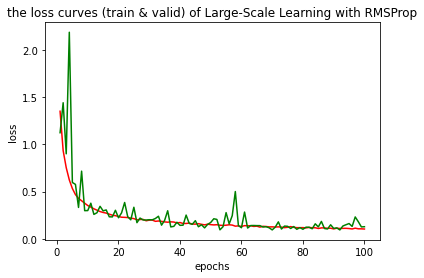

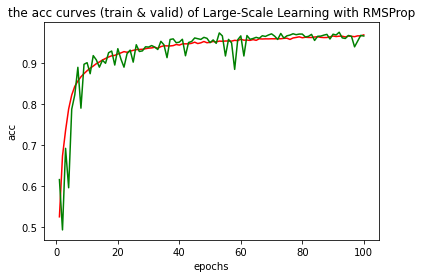

In [6]:
# use RMSProp
## about model
num_classes = 10

## about data
data_dir = "dataset/" ## You need to specify the data_dir first
input_size = 224
batch_size = 128

## about training
num_epochs = 100
lr = 0.001

## model initialization
model = model_A(num_classes=num_classes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

## data preparation
train_loader, valid_loader = load_data(data_dir=data_dir,input_size=input_size, batch_size=batch_size)

## optimizer
optimizer = optim.RMSprop(model.parameters(), lr=lr, alpha=0.9)
optimizer.name = 'RMSProp'

## loss function
criterion = nn.CrossEntropyLoss()
train_loss_curves,train_acc_curves,valid_loss_curves,valid_acc_curves = train_model(model,train_loader, valid_loader, criterion, optimizer, num_epochs=num_epochs)
show_loss_curve(train_loss_curves,valid_loss_curves,model.name+" with "+optimizer.name)
show_acc_curve(train_acc_curves,valid_acc_curves,model.name+" with "+optimizer.name)


## Use Adam

epoch:0/100
****************************************************************************************************
training: 1.1264, 0.6033
validation: 1.4151, 0.5885
epoch:1/100
****************************************************************************************************
training: 0.8296, 0.7108
validation: 0.7718, 0.7189
epoch:2/100
****************************************************************************************************
training: 0.6784, 0.7614
validation: 0.5737, 0.8013
epoch:3/100
****************************************************************************************************
training: 0.5767, 0.8023
validation: 0.5006, 0.8256
epoch:4/100
****************************************************************************************************
training: 0.5036, 0.8275
validation: 0.4851, 0.8400
epoch:5/100
****************************************************************************************************
training: 0.4442, 0.8512
validation: 0.7195, 0.7846
epoch:6/10

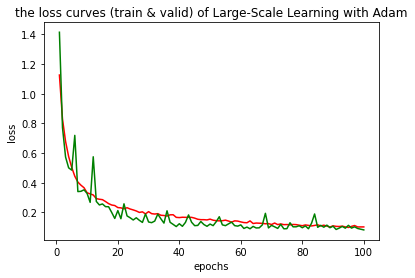

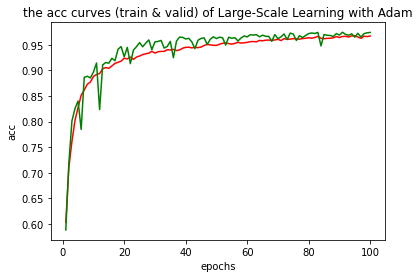

In [7]:
# use RMSProp
## about model
num_classes = 10

## about data
data_dir = "dataset/" ## You need to specify the data_dir first
input_size = 224
batch_size = 128

## about training
num_epochs = 100
lr = 0.001

## model initialization
model = model_A(num_classes=num_classes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

## data preparation
train_loader, valid_loader = load_data(data_dir=data_dir,input_size=input_size, batch_size=batch_size)

## optimizer
optimizer = optim.Adam(model.parameters(), lr=lr, betas=(0.9,0.999))
optimizer.name = 'Adam'

## loss function
criterion = nn.CrossEntropyLoss()
train_loss_curves,train_acc_curves,valid_loss_curves,valid_acc_curves = train_model(model,train_loader, valid_loader, criterion, optimizer, num_epochs=num_epochs)
show_loss_curve(train_loss_curves,valid_loss_curves,model.name+" with "+optimizer.name)
show_acc_curve(train_acc_curves,valid_acc_curves,model.name+" with "+optimizer.name)

## t-SNE

In [ ]:
def show_feature_using_tNSE(name='train',data_loader):
    

In [17]:
# t-NSE
model = load_model(device,"Large-Scale Learning","Adam")
num_features = model.fc.in_features
model_without_fc = nn.Sequential(*(list(model.children())[:-1]))


Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con